
## Play with Himawari cloud mask, group data by bins


In [ ]:
import os,sys
from glob import glob
#
import xarray as xr
import dask.array as da
#from dask.distributed import Client
#from dask.dot import dot_graph
# 
import numpy as np
import cartopy.crs as ccrs
#import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#
from utils import *

# jupyter nbconvert --to script hw_cloudmask_agglo.ipynb
# then uncomment matplotlib lines and make sure time indices are right in the main loop


In [ ]:
# data path
dpath = '/home/datawork-lops-osi/data/hw/mask/';
figdir = 'figs/'
#figdir = '/home1/datawork/aponte/hw/figs/'
try:
    os.stat(figdir)
except:
    os.mkdir(figdir)
    
filenames = sorted(glob(dpath+'*.nc'))
print 'Number of files available: %d' %len(filenames)
Nfiles = len(filenames)

# build time line from filenames and store ut ub tule coordinate
#fname_pref='NC_H08_'+YYYYMM+DD+'_'+hh+mm+'_L2CLPbet_FLDK.02401_02401.nc'
time = [datetime.strptime(f,dpath+'NC_H08_%Y%m%d_%H%M_L2CLPbet_FLDK.02401_02401.nc') for f in filenames]

In [3]:
#
t = datetime(2016,7,10,10,0)
#t = datetime(2016,7,10,10,30)
t = datetime(2016,7,10,0,30) 
mask = xr.open_dataset(filenames[time.index(t)])['QA']
chunks = {'longitude':150,'latitude':100}
mask = mask.chunk(chunks=chunks)

print mask

<xarray.DataArray 'QA' (latitude: 2401, longitude: 2401)>
dask.array<xarray-<this-array>, shape=(2401, 2401), dtype=float64, chunksize=(100, 150)>
Coordinates:
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 59.8 59.75 59.7 ...
  * longitude  (longitude) float32 80.0 80.05 80.1 80.15 80.2 80.25 80.3 ...
Attributes:
    long_name:    Quality Assurance
    units:        Dimensionless
    valid_min:    0
    valid_max:    65535
    description:  (2,1,0) Cloud Retrieval Algorithm Flag: 000=Outside of Scan...


In [4]:
# massage the mask to get cloud flag
fmask = process_raw_mask(mask)


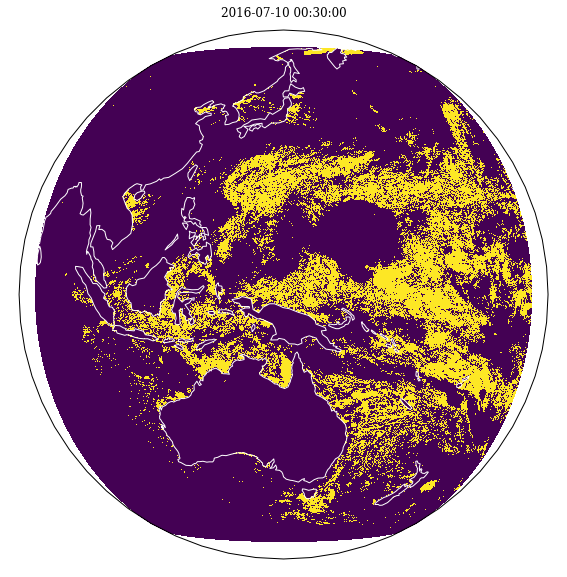

In [5]:
# plot one snapshot

# note, can't download coastlines from cluster nodes:
# wget http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
# (unzip, rename)
# mv 110m_coastline.* ~/.local/share/cartopy/shapefiles/natural_earth/physical/

# plot
plot_mask(fmask,title=str(t))
plt.savefig(figdir+'hw_snapshot.png')


<xarray.Dataset>
Dimensions:    (latitude: 239, longitude: 239)
Coordinates:
  * longitude  (longitude) float64 80.5 81.0 81.5 82.0 82.5 83.0 83.5 84.0 ...
  * latitude   (latitude) float64 -59.5 -59.0 -58.5 -58.0 -57.5 -57.0 -56.5 ...
Data variables:
    QA         (longitude, latitude) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


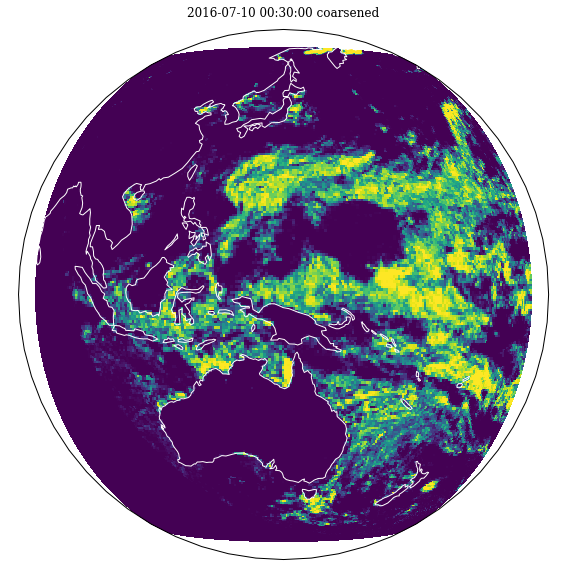

In [6]:
# with dask

# 2D bins
dl = 0.5
#mask['longitude'].max().values
#
cmask = coarsen(fmask, dl, chunks)
print cmask

#
#plot_mask(cmask['QA'],title=str(t)+' coarsened',colorbar=True)
plot_mask(cmask['QA'],title=str(t)+' coarsened')


In [31]:
# loop over time and store
#from utils import *
threshold=.8
Tmin=.5 # in days

# xarray aggregating time intervals
tagg = xr.zeros_like(cmask['QA'])

# reference time
t0 = datetime(2015,7,1,0,0,0)

# init data holder
s = twindow_manager(threshold,Tmin,dl,t0)

In [33]:
# main loop
write_log('dl=%.2f deg, threshold=%.2f, Tmin=%.1f h'%(dl, threshold,Tmin*24.))
#for i,f in enumerate(filenames[:48]):
#for i,f in enumerate(filenames):
for i,f in zip(range(0,48),filenames[:48]):
    tagg = process_mask_time(i, time[i], f, tagg, chunks, s)
    #print i


  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0  

In [ ]:
# plot one snapshot, fast

i=15
#i=30
f=filenames[i]

# load data
mask = xr.open_dataset(f)['QA']
# process
fmask = process_mask(mask)
#
plot_mask(fmask,colorbar=True,title=str(time[i]))
plt.savefig(figdir+'hw_fmask_%04d.jpg'%i,dpi=300)
# coarsen
cmask = coarsen(fmask)
print cmask.values
#
plot_mask(cmask['QA'],colorbar=True,title=str(time[i]))
plt.savefig(figdir+'hw_cmask_%04d.jpg'%i,dpi=300)



In [ ]:
# make a movie of the coarsened mask
figdir = '/home1/datawork/aponte/hw/figs/'

#for i,f in enumerate(filenames):
#for i,f in zip(range(0,48*2,12),filenames[:48*2]):
for i,f in enumerate(filenames[:2*24*10]):
    log = str(time[i])
    # load data
    mask = xr.open_dataset(f)['QA']
    # process
    fmask = process_raw_mask(mask)
    # coarsen
    cmask = coarsen(fmask)
    #
    plot_mask(cmask['QA'],colorbar=True,title=log)
    plt.savefig(figdir+'hw_mask_%04d.jpg'%i,dpi=300)
    #
    write_log(log)

In [ ]:
# plot time intervals between files

plt.figure()
ts = np.array([(t-t0).total_seconds()/3600. for t in time])
plt.plot(np.diff(ts))
plt.ylabel('[hour]')
plt.title('Time interval between files')
plt.show()

---

## Old code below

In [ ]:

# bin by latitude with groupby (xarray)

mask_gp = fmask.groupby_bins('latitude', lat_bins, labels=lat_center).mean()
#mask_gp = fmask.groupby_bins('latitude', lat_bins, labels=lat_center)
#print mask_gp
#mask_gp = mask_gp.mean()
#
print mask_gp

plt.figure()
mask_gp.plot()
plt.show()



In [ ]:
# 2D groupby with xarray, coarsening, does not work at the moment
v1min, v1max, dv1= lon_bins[0], lon_bins[-1], dl
v2min, v2max, dv2= lat_bins[0], lat_bins[-1], dl
i1max = int(np.rint((v1max-v1min)/dv1))+1
i2max = int(np.rint((v2max-v2min)/dv2))+1
fmaskt = fmask.copy(deep=True).to_dataset()
fmaskt['ijbin'] = np.minimum(np.maximum(np.floor((fmaskt['longitude']-v1min)/dv1)+1,0),i1max) \
                    +np.minimum(np.maximum(np.floor((fmaskt['latitude']-v2min)/dv2)+1,0),i2max)*(i1max+1)
print fmaskt.QA
print fmaskt.ijbin # not chunked anymore

#print fmaskt
plt.figure()
fmaskt['ijbin'].plot()
plt.show()

## this takes for ever
#mask_gp = fmaskt.groupby_bins('ijbin', np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.)).mean()
#print mask_gp
